In [1]:
import pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import model_selection
from sklearn import linear_model as lm
from sklearn import preprocessing
from sklearn import pipeline
from sklearn import tree
from sklearn.preprocessing import StandardScaler

import os

os.environ['PATH'] = os.environ['PATH'] + ';C:/Program Files (x86)/Graphviz2.38/bin'

pandas.set_option("display.precision", 2)

datafile = '../../Data/Raw/wine/winequality-red.csv'



feature_norm  = False


target_variable = ['quality']
classifier_variables = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
                      'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
                      'pH', 'sulphates', 'alcohol', ]

In [2]:
%run functions.ipynb

# Load Data 

In [3]:
data = pandas.read_csv(datafile, sep=';')
print(data.shape)
print(data.columns)
data.head()

(1599, 12)
Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9       0.08   
1            7.8              0.88         0.00             2.6       0.10   
2            7.8              0.76         0.04             2.3       0.09   
3           11.2              0.28         0.56             1.9       0.07   
4            7.4              0.70         0.00             1.9       0.08   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0      1.0  3.51       0.56   
1                 25.0                  67.0      1.0  3.20       0.68   
2                 15.0                  54.0      1.0  3.26       0.65   
3                 17.0                  60.0      1.0  3.16       0.58   
4                 11.0                  34.0      1.0  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

# Descrição dos Dados

In [4]:
data.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count        1599.00           1599.00      1599.00         1599.00   
mean            8.32              0.53         0.27            2.54   
std             1.74              0.18         0.19            1.41   
min             4.60              0.12         0.00            0.90   
25%             7.10              0.39         0.09            1.90   
50%             7.90              0.52         0.26            2.20   
75%             9.20              0.64         0.42            2.60   
max            15.90              1.58         1.00           15.50   

       chlorides  free sulfur dioxide  total sulfur dioxide   density  \
count    1599.00              1599.00               1599.00  1.60e+03   
mean        0.09                15.87                 46.47  9.97e-01   
std         0.05                10.46                 32.90  1.89e-03   
min         0.01                 1.00                  6.00  9.90e-01   
25%         0.07                 7.00                 22.00  9.96e-01   
50%         0.08                14.00                 38.00  9.97e-01   
75%         0.09                21.00                 62.00  9.98e-01   
max         0.61                72.00                289.00  1.00e+00   

            pH  sulphates  alcohol  quality  
count  1599.00    1599.00  1599.00  1599.00  
mean      3.31       0.66    10.42     5.64  
std       0.15       0.17     1.07     0.81  
min       2.74       0.33     8.40     3.00  
25%       3.21       0.55     9.50     5.00  
50%       3.31       0.62    10.20     6.00  
75%       3.40       0.73    11.10     6.00  
max       4.01       2.00    14.90     8.00

# Normalização dos dados 

In [5]:
if feature_norm:
    data[classifier_variables] = preprocessing.power_transform(data[classifier_variables], method='yeo-johnson')

# Validação Cruzada 

In [6]:
X = data[classifier_variables].values
Y = data[target_variable].values
idx = Y > 5
classes=['baixa qualidade','alta qualidade']
Y[idx] = 1
Y[~idx]= 0

# Dividir 20% dos dados para o conjunto out-of-sample de teste
Xtrain, Xtest, Ytrain, Ytest = model_selection.train_test_split(X,
                                                                Y,
                                                                test_size=0.2,
                                                                random_state=0,
                                                                stratify=Y)

# Objeto de validacao cruzada
cvfold = model_selection.StratifiedKFold(n_splits = 10, random_state = 0)

# Curvas de Aprendizado 

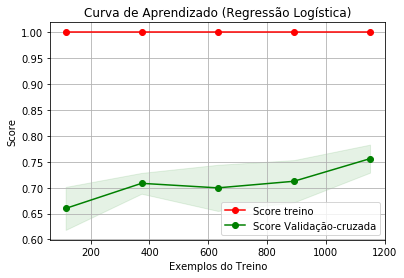

In [7]:
plt.figure()

scorer = metrics.make_scorer(metrics.accuracy_score)

title = "Curva de Aprendizado (Regressão Logística)"
estimator = tree.DecisionTreeClassifier(random_state=0)
plot_learning_curve(estimator, title, Xtrain, Ytrain, ax=plt.gca(),
                    cv=cvfold.split(Xtrain, Ytrain, groups=Ytrain),
                    scoring=scorer, n_jobs=3)


# Pipeline de Treinamento 

In [8]:
# Configure Pipeline
conf_train_pipe = [
    ('Scaler', StandardScaler()),
    ('Model', tree.DecisionTreeClassifier( random_state = 0)),
]

# Create Pipeline
model_pipe = pipeline.Pipeline(conf_train_pipe)

param_grid = {
    'Model__max_depth': [4,5,6,8,10,12],
}

model_pipe = model_selection.GridSearchCV(model_pipe, param_grid,
                                     scoring=None,
                                     fit_params=None,
                                     cv=cvfold)

model_pipe.fit(Xtrain, Ytrain)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=False),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('Scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('Model', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'Model__max_depth': [4, 5, 6, 8, 10, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

## Estimativa do Modelo 

In [9]:
Yhat = model_pipe.predict_proba(Xtest)[:,1]
Ypred= model_pipe.predict(Xtest)
print('Yhat.shape:', Yhat.shape)

Yhat.shape: (320,)


# Distribuições 

C:\Users\BZ241WX\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


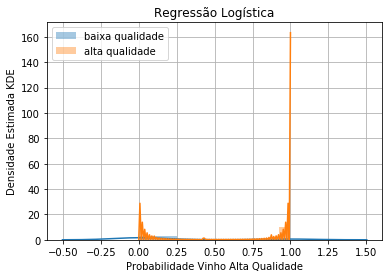

In [10]:
for i in range(len(classes)):
    # 2 Classes case
    sns.distplot(Yhat[Ytest[:,0] == i], label=classes[i])

plt.title('Regressão Logística')
plt.ylabel('Densidade Estimada KDE')
plt.xlabel('Probabilidade Vinho Alta Qualidade')
plt.grid()
plt.legend()

# Curvas ROC 

Text(0, 0.5, 'Taxa de Detecção')

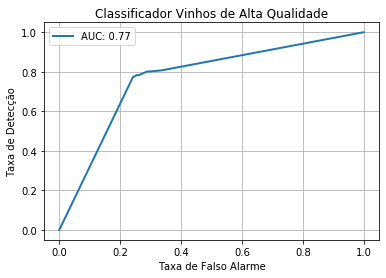

In [11]:
# help(metrics.roc_curve)
plt.figure()
fpr, tpr, thr = metrics.roc_curve(Ytest, Yhat)
auc = metrics.roc_auc_score(Ytest, Yhat)
plt.plot(fpr, tpr, '-', lw=2, label='AUC: %.2f'%(auc))
plt.legend()
plt.title('Classificador Vinhos de Alta Qualidade')
plt.grid()
plt.xlabel('Taxa de Falso Alarme')
plt.ylabel('Taxa de Detecção')

## Matriz de Confusão 

In [12]:
col_names = ['Model ' + s for s in classes]
idx_names = ['Real ' + s for s in classes]

cmat = metrics.confusion_matrix(Ytest, Ypred)
cmat = pandas.DataFrame(cmat, index=idx_names,
                              columns=col_names)
cmat['Real Total'] = cmat.sum(axis=1)
cmat.loc['Model Total',:] = cmat.sum(axis=0)
cmat = cmat.astype(int)
cmat

Model baixa qualidade  Model alta qualidade  Real Total
Real baixa qualidade                    111                    38         149
Real alta qualidade                      37                   134         171
Model Total                             148                   172         320

## Classification Report 

In [13]:
print(metrics.classification_report(Ytest, Ypred, target_names=classes))

                 precision    recall  f1-score   support

baixa qualidade       0.75      0.74      0.75       149
 alta qualidade       0.78      0.78      0.78       171

      micro avg       0.77      0.77      0.77       320
      macro avg       0.76      0.76      0.76       320
   weighted avg       0.77      0.77      0.77       320



# Scores da Validacao Cruzada 

In [14]:
print('Train')
print('\tScore:', np.mean(model_pipe.cv_results_['mean_train_score']),
       '+-'     , np.mean(model_pipe.cv_results_['std_train_score']))
print('Test')
print('\tScore:', np.mean(model_pipe.cv_results_['mean_test_score']),
       '+-'     , np.mean(model_pipe.cv_results_['std_test_score']))

Train
	Score: 0.8676616194207655 +- 0.009192486582145297
Test
	Score: 0.7323429762835548 +- 0.03518441680200446


C:\Users\BZ241WX\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\BZ241WX\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


## Calibration Plot 

C:\Users\BZ241WX\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\BZ241WX\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\BZ241WX\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\BZ241WX\AppData\Local\Continuum\anaconda3\li

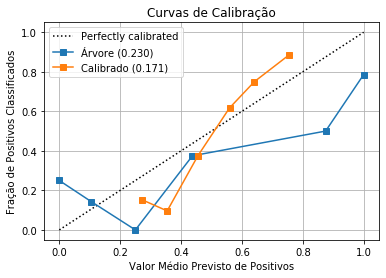

In [15]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Calibrated with sigmoid calibration
calib_sigmoid = CalibratedClassifierCV(model_pipe, cv=5, method='sigmoid')
calib_sigmoid.fit(Xtrain, Ytrain)
Ypred_calib = calib_sigmoid.predict(Xtest)
Yhat_calib  = calib_sigmoid.predict_proba(Xtest)[:,1]


# Modelo perfeito
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

# Modelo logistico puro
clf_score = metrics.brier_score_loss(Ytest, Yhat, pos_label=1)
fraction_of_positives, mean_predicted_value = calibration_curve(Ytest, Yhat, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Árvore (%1.3f)" %clf_score)

# Modelo calibrado
clf_score = metrics.brier_score_loss(Ytest, Yhat_calib, pos_label=1)
fraction_of_positives, mean_predicted_value = calibration_curve(Ytest, Yhat_calib, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Calibrado (%1.3f)" %clf_score)


plt.ylabel("Fração de Positivos Classificados")
plt.xlabel("Valor Médio Previsto de Positivos")
plt.ylim([-0.05, 1.05])
plt.title('Curvas de Calibração')
plt.legend()
plt.grid()

# Distribuicao Calibrada 

C:\Users\BZ241WX\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


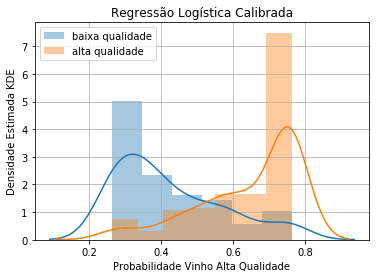

In [16]:
for i in range(len(classes)):
    # 2 Classes case
    sns.distplot(Yhat_calib[Ytest[:,0] == i], label=classes[i])

plt.title('Regressão Logística Calibrada')
plt.ylabel('Densidade Estimada KDE')
plt.xlabel('Probabilidade Vinho Alta Qualidade')
plt.grid()
plt.legend()

# ROC Calibrada

Text(0, 0.5, 'Taxa de Detecção')

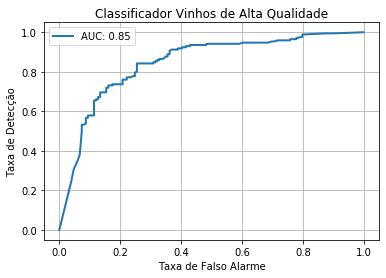

In [17]:
# help(metrics.roc_curve)
plt.figure()
fpr, tpr, thr = metrics.roc_curve(Ytest, Yhat_calib)
auc = metrics.roc_auc_score(Ytest, Yhat_calib)
plt.plot(fpr, tpr, '-', lw=2, label='AUC: %.2f'%(auc))
plt.legend()
plt.title('Classificador Vinhos de Alta Qualidade')
plt.grid()
plt.xlabel('Taxa de Falso Alarme')
plt.ylabel('Taxa de Detecção')

# Diagrama com a Árvore 

In [18]:
data.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

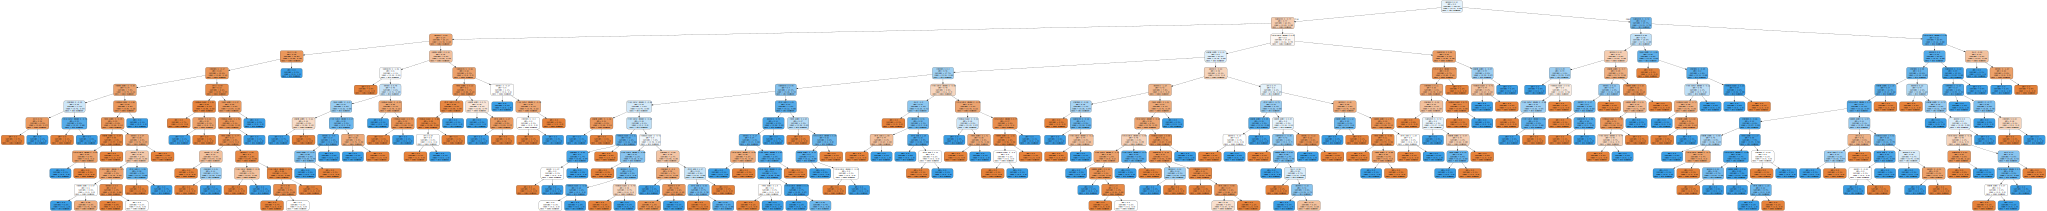

In [25]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydot


dot_data = StringIO()

clf_tree = model_pipe.best_estimator_.steps[1][1]

dot_data = export_graphviz(clf_tree,  
                            filled=True, rounded=True,
                            special_characters=True,
                            feature_names=classifier_variables,
                            precision=2,
                            proportion=True,
                            class_names=classes)
graph = graphviz.Source(dot_data)  
graph 